# Basic Classifying VAE for MNIST Database

In [1]:
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import torch
import pprint
import numpy as np
import numpy.random as random
import datetime
from src.pytorch_cl_vae.model import ClVaeModel
import matplotlib.pyplot as plt
from collections import defaultdict

## 1 - Specify parameters for to the VAE and training

In [2]:
params = {
    'batch_size': 100,
    'num_epochs': 10,
    'latent_dim': 20,
    'encoder_hidden_size': 512,
    'decoder_hidden_size': 512,
    'classifier_hidden_size': 512,
    'vae_learning_rate': 0.0001,
    'classifier_learning_rate': 0.0001,
    'log_dir': '../data/logs',
    'model_dir': '../data/models',
    'data_dir': '../data'
}

## 2 - Fetch MNIST

In [3]:
mnist = fetch_mldata('MNIST original', data_home=params['data_dir'])
mnist.data = mnist.data / 255
num_samples, input_dim = mnist.data.shape
num_classes = len(np.unique(mnist.target))
lb = preprocessing.LabelBinarizer()
lb.fit(mnist.target)
params['classes_dim'] = [num_classes]
params['original_dim'] = input_dim
print('MNIST db has been successfully loaded, stored in the: "{}"'.format(params['data_dir'] + '/mldata'))
# split data to train and test subsets
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.1, random_state=0)
print("| Train subset shape:{} | Test subset shape:{} |".format(X_train.shape, X_test.shape))

MNIST db has been successfully loaded, stored in the: "../data/mldata"
| Train subset shape:(63000, 784) | Test subset shape:(7000, 784) |


## 3 - Create Model

In [4]:
# Initialize ClVaeModel
model = ClVaeModel(**params)
print("Model successfully initialized with params: ")
pprint.PrettyPrinter(indent=4).pprint(params)

train_losses = []
train_accuracies = []

Model successfully initialized with params: 
{   'batch_size': 100,
    'classes_dim': [10],
    'classifier_hidden_size': 512,
    'classifier_learning_rate': 0.0001,
    'data_dir': '../data',
    'decoder_hidden_size': 512,
    'encoder_hidden_size': 512,
    'latent_dim': 20,
    'log_dir': '../data/logs',
    'model_dir': '../data/models',
    'num_epochs': 10,
    'original_dim': 784,
    'vae_learning_rate': 0.0001}


## 4 - Train

In [5]:
save_each_steps = 500

# Train loop
train_step_i = 0
for epoch in range(params['num_epochs']):
    print('\nepoch {} out of {}'.format(epoch + 1, params['num_epochs']))
    for i in range(X_train.shape[0] // params['batch_size']):
        # Sample batch
        idx = random.choice(np.arange(0, X_train.shape[0]), params['batch_size'])
        x_batch = torch.from_numpy(X_train[idx]).float()
        y_batch = lb.transform(y_train[idx])
        y_batch = [torch.from_numpy(y_batch).float()]
        step_losses, step_accuracies = model.train_step(x_batch, y_batch)

#         step_losses = [loss.sum().detach().numpy() for loss in step_losses]
        # step_losses = Losses(*step_losses)
        # step_accuracies = Accuracies(*step_accuracies)

        train_losses.append(step_losses)
        train_accuracies.append(step_accuracies)

        train_step_i += 1

        print("\r|train step: {} | rec loss: {:.4f} | z_dkl loss: {:.4f} | class loss: {:.4f}"
              " | w_dkl loss: {:.4f} | class_accuracy: {:.4f} |".format(
            train_step_i, *step_losses, *step_accuracies
            ), end='')
        if train_step_i % 100 == 0:
            print()
        if train_step_i % save_each_steps == 0:
            dt = str(datetime.datetime.now().strftime("%m_%d_%Y_%I_%M_%p"))
            fname = params['model_dir'] + '/cl_vae_mnist_{}.pt'.format(dt)
            model.save_ckpt(fname)
print('*****Finished with the final loss: ', step_losses)


epoch 1 out of 10
|train step: 100 | rec loss: 194.1559 | z_dkl loss: 2.5864 | class loss: 2.2220 | w_dkl loss: 0.0992 | class_accuracy: 0.2700 |
|train step: 200 | rec loss: 184.0654 | z_dkl loss: 4.1617 | class loss: 2.2219 | w_dkl loss: 0.1114 | class_accuracy: 0.2700 |
|train step: 300 | rec loss: 169.0450 | z_dkl loss: 7.0289 | class loss: 2.1905 | w_dkl loss: 0.0777 | class_accuracy: 0.3700 |
|train step: 400 | rec loss: 146.7113 | z_dkl loss: 9.6812 | class loss: 2.2130 | w_dkl loss: 0.0741 | class_accuracy: 0.3200 ||
|train step: 500 | rec loss: 146.3992 | z_dkl loss: 10.6667 | class loss: 2.1887 | w_dkl loss: 0.0628 | class_accuracy: 0.3800 |
|train step: 600 | rec loss: 138.3581 | z_dkl loss: 10.8554 | class loss: 2.2142 | w_dkl loss: 0.0697 | class_accuracy: 0.3200 |
|train step: 630 | rec loss: 140.5607 | z_dkl loss: 9.6371 | class loss: 2.2063 | w_dkl loss: 0.0698 | class_accuracy: 0.3500 ||
epoch 2 out of 10
|train step: 700 | rec loss: 140.8935 | z_dkl loss: 11.6892 | c

|train step: 5400 | rec loss: 90.0631 | z_dkl loss: 18.1426 | class loss: 2.1886 | w_dkl loss: 0.0188 | class_accuracy: 0.3500 |
|train step: 5500 | rec loss: 83.9149 | z_dkl loss: 18.7142 | class loss: 2.1906 | w_dkl loss: 0.0239 | class_accuracy: 0.3900 |
|train step: 5600 | rec loss: 91.5578 | z_dkl loss: 19.9001 | class loss: 2.2062 | w_dkl loss: 0.0200 | class_accuracy: 0.3400 |
|train step: 5670 | rec loss: 86.2346 | z_dkl loss: 18.5304 | class loss: 2.1721 | w_dkl loss: 0.0201 | class_accuracy: 0.4100 |
epoch 10 out of 10
|train step: 5700 | rec loss: 87.9154 | z_dkl loss: 19.6143 | class loss: 2.2092 | w_dkl loss: 0.0221 | class_accuracy: 0.3300 |
|train step: 5800 | rec loss: 87.9392 | z_dkl loss: 18.9496 | class loss: 2.1930 | w_dkl loss: 0.0234 | class_accuracy: 0.3700 |
|train step: 5900 | rec loss: 87.7468 | z_dkl loss: 20.1799 | class loss: 2.1585 | w_dkl loss: 0.0224 | class_accuracy: 0.4300 |
|train step: 6000 | rec loss: 90.1038 | z_dkl loss: 19.0912 | class loss: 2.21

## 5 - Show losses graph

('rec_loss', 'z_dkl_loss', 'class_loss_0', 'w_dkl_loss_0')
tensor(0.6944, grad_fn=<BinaryCrossEntropyBackward>) tensor(0.0288, grad_fn=<DivBackward0>) tensor(2.3071, grad_fn=<NllLossBackward>) tensor(0.4588, grad_fn=<DivBackward0>)


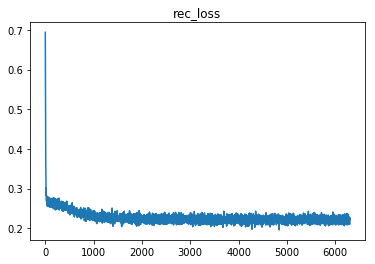

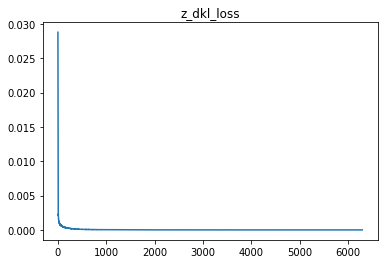

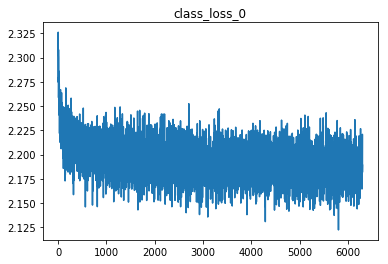

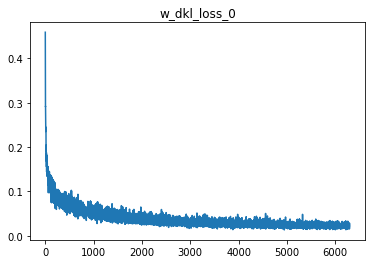

In [6]:
%matplotlib inline
losses = defaultdict(list)
losses_names = train_losses[0]._fields
print(losses_names)
step_loss = train_losses[0]
print(*step_loss)
for i, loss_name in enumerate(losses_names):
    losses[loss_name] = [l[i] for l in train_losses]
    plt.figure()
    plt.title(loss_name)
    plt.plot(losses[loss_name])
    plt.legend()
plt.show()

## 6 - Test

In [7]:
y_test = lb.transform(y_test)
losses, acc = model.test(torch.from_numpy(X_test).float(), [torch.from_numpy(y_test).float()])
pprint.PrettyPrinter(indent=4).pprint(losses)

Losses(rec_loss=tensor(0.2667), z_dkl_loss=tensor(0.0654), class_loss_0=tensor(2.3070), w_dkl_loss_0=tensor(0.1143))


## 7 - Examples

In [ ]:
#TODO

